In [1]:
import pandas as pd
import sklearn
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

Dataframe from MDA_merge_data.ipynb is loaded, datetime column is dropped in order to run model.

In [2]:
df = pd.read_csv("C:\\Users\Arthur\hello\\final_df.csv", delimiter=";")
df['255439'] = df['object_id']==255439
df['255440'] = df['object_id']==255440
df['255441'] = df['object_id']==255441
df['255442'] = df['object_id']==255442
df['255443'] = df['object_id']==255443
df['255444'] = df['object_id']==255444
df['255445'] = df['object_id']==255445
df['280324'] = df['object_id']==280324
df['303910'] = df['object_id']==303910
df = df.sort_values(by=['result_timestamp','object_id'])


In [3]:
df['key'] = df['object_id'].astype('str') + df['result_timestamp']
df['result_timestamp'] = pd.to_datetime(df['result_timestamp'],format='%Y-%m-%d %H:%M:%S')


In [4]:
df_noisedelay = df[['object_id','result_timestamp','laeq']]
df_noisedelay['result_timestamp'] = df_noisedelay['result_timestamp']+pd.DateOffset(days=1)
df_noisedelay['laeq_delayed'] = df_noisedelay['laeq']
df_noisedelay['key'] = df_noisedelay['object_id'].astype('str') + df_noisedelay['result_timestamp'].astype('str')
df_noisedelay = df_noisedelay.drop(['laeq','object_id','result_timestamp'], axis=1)

df_weatherdelay = df[['object_id','result_timestamp','LC_HUMIDITY','LC_DWPTEMP','LC_n','LC_RAD','LC_RAININ',
                   'LC_DAILYRAIN','LC_WINDDIR','LC_WINDSPEED','LC_RAD60','LC_TEMP_QCL0']]
df_weatherdelay['result_timestamp'] = df_weatherdelay['result_timestamp']+pd.DateOffset(days=1)
df_weatherdelay['key'] = df_weatherdelay['object_id'].astype('str') + df_weatherdelay['result_timestamp'].astype('str')
df_weatherdelay = df_weatherdelay.drop(['object_id','result_timestamp'], axis=1)
df = df.drop(['LC_HUMIDITY','LC_DWPTEMP','LC_n','LC_RAD','LC_RAININ',
                'LC_DAILYRAIN','LC_WINDDIR','LC_WINDSPEED','LC_RAD60','LC_TEMP_QCL0'],axis=1)


C:\Users\Arthur\AppData\Local\Temp\ipykernel_14316\727566501.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_noisedelay['result_timestamp'] = df_noisedelay['result_timestamp']+pd.DateOffset(days=1)
C:\Users\Arthur\AppData\Local\Temp\ipykernel_14316\727566501.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_noisedelay['laeq_delayed'] = df_noisedelay['laeq']
C:\Users\Arthur\AppData\Local\Temp\ipykernel_14316\727566501.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

In [5]:
df = pd.merge(df,df_noisedelay, on='key',validate='1:1')
df= pd.merge(df,df_weatherdelay, on='key',validate='1:1')
df_nd = df.drop(['key','object_id','result_timestamp','date','time','day_time','day_hour','LC_TEMP_QCL1','LC_TEMP_QCL2','LC_TEMP_QCL3'], axis=1)

In [6]:
df_nd.isna().sum()


laeq             0
hour             0
weekday          0
month            0
weekend          0
holiday          0
exam_period      0
255439           0
255440           0
255441           0
255442           0
255443           0
255444           0
255445           0
280324           0
303910           0
laeq_delayed     0
LC_HUMIDITY     43
LC_DWPTEMP      43
LC_n            43
LC_RAD          43
LC_RAININ       43
LC_DAILYRAIN    43
LC_WINDDIR      43
LC_WINDSPEED    43
LC_RAD60         4
LC_TEMP_QCL0    43
dtype: int64

In [7]:
df_nd = df_nd[df_nd.isna()['LC_HUMIDITY']==False]
df_nd.isna().sum()

laeq            0
hour            0
weekday         0
month           0
weekend         0
holiday         0
exam_period     0
255439          0
255440          0
255441          0
255442          0
255443          0
255444          0
255445          0
280324          0
303910          0
laeq_delayed    0
LC_HUMIDITY     0
LC_DWPTEMP      0
LC_n            0
LC_RAD          0
LC_RAININ       0
LC_DAILYRAIN    0
LC_WINDDIR      0
LC_WINDSPEED    0
LC_RAD60        0
LC_TEMP_QCL0    0
dtype: int64

In [8]:
df_nd['weekday'] = df_nd['weekday'].replace(to_replace='Monday', value=0)
df_nd['weekday'] = df_nd['weekday'].replace(to_replace='Tuesday', value=1)
df_nd['weekday'] = df_nd['weekday'].replace(to_replace='Wednesday', value=2)
df_nd['weekday'] = df_nd['weekday'].replace(to_replace='Thursday', value=3)
df_nd['weekday'] = df_nd['weekday'].replace(to_replace='Friday', value=4)
df_nd['weekday'] = df_nd['weekday'].replace(to_replace='Saturday', value=5)
df_nd['weekday'] = df_nd['weekday'].replace(to_replace='Sunday', value=6)

The target dataset (y) and predictor dataset (X) are created. For y, noise is converted to relative noise (proportion of max value)

In [9]:
y = df_nd["laeq"]
X = df_nd.drop(["laeq","laeq_delayed"], axis="columns")

In [10]:
#create time-sensitive split for cross-validation
ts_cv = TimeSeriesSplit(
    n_splits=5,
    gap=38880,
    max_train_size=66000,
    test_size=30000,
)

In [11]:
#inspect splits
all_splits = list(ts_cv.split(X, y))
train_0, test_0 = all_splits[0]
X.iloc[test_0]
X.iloc[train_0]

,hour,weekday,month,weekend,holiday,exam_period,255439,255440,255441,255442,...,LC_HUMIDITY,LC_DWPTEMP,LC_n,LC_RAD,LC_RAININ,LC_DAILYRAIN,LC_WINDDIR,LC_WINDSPEED,LC_RAD60,LC_TEMP_QCL0
75280,13,5,4,True,True,False,False,False,False,False,...,56.0,8.70,32.0,420.0,0.0,0.0,110.0,0.37,496.0,17.65
75281,13,5,4,True,True,False,False,False,False,False,...,56.0,8.70,32.0,420.0,0.0,0.0,110.0,0.37,496.0,17.65
75282,13,5,4,True,True,False,False,False,False,False,...,56.0,8.70,32.0,420.0,0.0,0.0,110.0,0.37,496.0,17.65
75283,13,5,4,True,True,False,True,False,False,False,...,56.0,8.57,32.0,92.0,0.0,0.0,-44.0,0.05,492.0,17.57
75284,13,5,4,True,True,False,False,False,True,False,...,56.0,8.57,32.0,92.0,0.0,0.0,-44.0,0.05,492.0,17.57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141275,1,1,6,False,False,True,False,False,False,False,...,82.0,11.85,31.0,0.0,0.0,0.0,111.0,0.05,0.0,14.76
141276,1,1,6,False,False,True,True,False,False,False,...,82.0,11.61,32.0,0.0,0.0,0.0,83.0,0.09,0.0,14.60
141277,1,1,6,False,False,True,False,True,False,False,...,82.0,11.61,32.0,0.0,0.0,0.0,83.0,0.09,0.0,14.60
141278,1,1,6,False,False,True,False,False,True,False,...,82.0,11.61,32.0,0.0,0.0,0.0,83.0,0.09,0.0,14.60


In [12]:
train_4, test_4 = all_splits[4]
X.iloc[test_4]
X.iloc[train_4]

,hour,weekday,month,weekend,holiday,exam_period,255439,255440,255441,255442,...,LC_HUMIDITY,LC_DWPTEMP,LC_n,LC_RAD,LC_RAININ,LC_DAILYRAIN,LC_WINDDIR,LC_WINDSPEED,LC_RAD60,LC_TEMP_QCL0
195280,14,5,8,True,True,False,False,False,False,False,...,21.0,7.93,32.0,550.0,0.0,0.0,94.0,0.22,578.0,33.04
195281,15,5,8,True,True,False,True,False,False,False,...,21.0,7.92,31.0,545.0,0.0,0.0,87.0,0.63,572.0,33.16
195282,15,5,8,True,True,False,False,True,False,False,...,21.0,7.92,31.0,545.0,0.0,0.0,87.0,0.63,572.0,33.16
195283,15,5,8,True,True,False,False,False,True,False,...,21.0,7.92,31.0,545.0,0.0,0.0,87.0,0.63,572.0,33.16
195284,15,5,8,True,True,False,False,False,False,True,...,21.0,7.92,31.0,545.0,0.0,0.0,87.0,0.63,572.0,33.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261314,13,0,10,False,False,False,False,False,False,False,...,70.0,14.75,37.0,114.0,0.0,0.0,-176.0,0.10,115.0,20.33
261315,13,0,10,False,False,False,False,False,False,False,...,70.0,14.75,37.0,114.0,0.0,0.0,-176.0,0.10,115.0,20.33
261316,13,0,10,False,False,False,False,False,False,False,...,70.0,14.75,37.0,114.0,0.0,0.0,-176.0,0.10,115.0,20.33
261317,13,0,10,False,False,False,False,False,False,False,...,70.0,14.75,37.0,114.0,0.0,0.0,-176.0,0.10,115.0,20.33


In [26]:
# grid search for hyperparameter tuning

param_grid = {
    'learning_rate': (0.05,0.06,0.07,0.08,0.09),
    'n_estimators': (80,90,100,110,120),
    'max_depth' : (5,6,7,8,9)}
model = xgb.XGBRegressor()
model_grid_search = GridSearchCV(model, param_grid=param_grid,
                                 n_jobs=2, cv=ts_cv)
model_grid_search.fit(X, y)


GridSearchCV(cv=TimeSeriesSplit(gap=38880, max_train_size=66000, n_splits=5, test_size=30000),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=No...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             n_jobs=2,
             param_grid={'learning_rate': (0.05, 0.06, 0.07, 0.08, 0.09),
                         'max_depth': (5, 6, 7, 8, 9),
                         'n_estimators': (80, 90, 100, 110, 120)})

In [27]:
accuracy = model_grid_search.score(X, y)
print(
    f"The test accuracy score of the grid-searched pipeline is: "
    f"{accuracy:.2f}"
)

The test accuracy score of the grid-searched pipeline is: 0.79


In [28]:
model_grid_search.predict(X.iloc[0:5])

array([48.53487 , 42.587067, 42.15027 , 40.29818 , 48.53487 ],
      dtype=float32)

In [29]:
print(f"The best set of parameters is: "
      f"{model_grid_search.best_params_}")

The best set of parameters is: {'learning_rate': 0.09, 'max_depth': 5, 'n_estimators': 110}


In [30]:
cv_results = pd.DataFrame(model_grid_search.cv_results_).sort_values(
    "mean_test_score", ascending=False)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
103,7.017235,1.048434,0.148960,0.016739,0.09,5,110,"{'learning_rate': 0.09, 'max_depth': 5, 'n_est...",0.678199,0.645700,0.220168,0.499848,0.593731,0.527529,0.165097,1
102,6.684469,0.412951,0.144342,0.005004,0.09,5,100,"{'learning_rate': 0.09, 'max_depth': 5, 'n_est...",0.681318,0.637642,0.220037,0.510081,0.586278,0.527071,0.163757,2
104,7.137132,0.366779,0.146743,0.006961,0.09,5,120,"{'learning_rate': 0.09, 'max_depth': 5, 'n_est...",0.678493,0.652684,0.221038,0.479006,0.596894,0.525623,0.167056,3
54,6.881990,0.307165,0.154122,0.011891,0.07,5,120,"{'learning_rate': 0.07, 'max_depth': 5, 'n_est...",0.683486,0.635945,0.212703,0.528051,0.566069,0.525251,0.165319,4
108,7.742367,0.122918,0.145930,0.009389,0.09,6,110,"{'learning_rate': 0.09, 'max_depth': 6, 'n_est...",0.687020,0.633856,0.204356,0.501466,0.597644,0.524869,0.171315,5


In [31]:
# get the parameter names
column_results = [f"param_{name}" for name in param_grid.keys()]
column_results += [
    "mean_test_score", "std_test_score", "rank_test_score"]
cv_results = cv_results[column_results]

In [32]:
def shorten_param(param_name):
    if "__" in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name


cv_results = cv_results.rename(shorten_param, axis=1)
cv_results

,param_learning_rate,param_n_estimators,param_max_depth,mean_test_score,std_test_score,rank_test_score
103,0.09,110,5,0.527529,0.165097,1
102,0.09,100,5,0.527071,0.163757,2
104,0.09,120,5,0.525623,0.167056,3
54,0.07,120,5,0.525251,0.165319,4
108,0.09,110,6,0.524869,0.171315,5
...,...,...,...,...,...,...
10,0.05,80,7,0.472426,0.217896,121
21,0.05,90,9,0.470775,0.212043,122
0,0.05,80,5,0.466184,0.216791,123
15,0.05,80,8,0.463043,0.227299,124


In [33]:
pivoted_cv_results = cv_results.pivot_table(
    values="mean_test_score", index=["param_max_depth"],
    columns=["param_n_estimators"])

pivoted_cv_results

param_n_estimators,80,90,100,110,120
param_max_depth,,,,,
5,0.501330,0.510403,0.515125,0.517942,0.518655
6,0.508076,0.514450,0.517571,0.519756,0.521014
7,0.502037,0.508540,0.510785,0.513671,0.514490
8,0.492960,0.499947,0.503448,0.504790,0.504832
9,0.481134,0.488788,0.493783,0.495584,0.497179


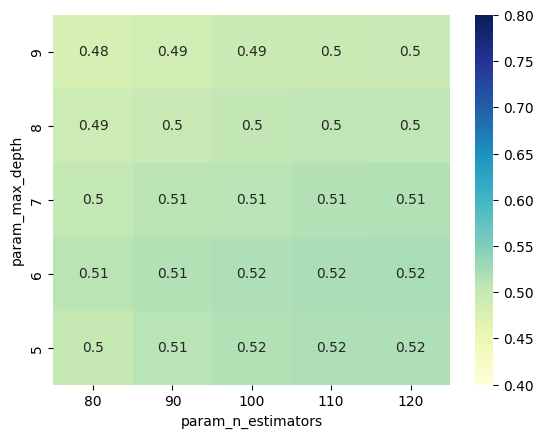

In [34]:
import seaborn as sns

ax = sns.heatmap(pivoted_cv_results, annot=True, cmap="YlGnBu", vmin=0.4,
                 vmax=0.8)
ax.invert_yaxis()

In [35]:
#run XGBoost model
def evaluate(model, X, y, cv):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"],
    )
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    print(
        f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}"
    )

gbrt_pipeline = xgb.XGBRegressor(learning_rate=0.09,n_estimators=110,max_depth=5)

evaluate(gbrt_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     3.010 +/- 0.323
Root Mean Squared Error: 4.169 +/- 0.485


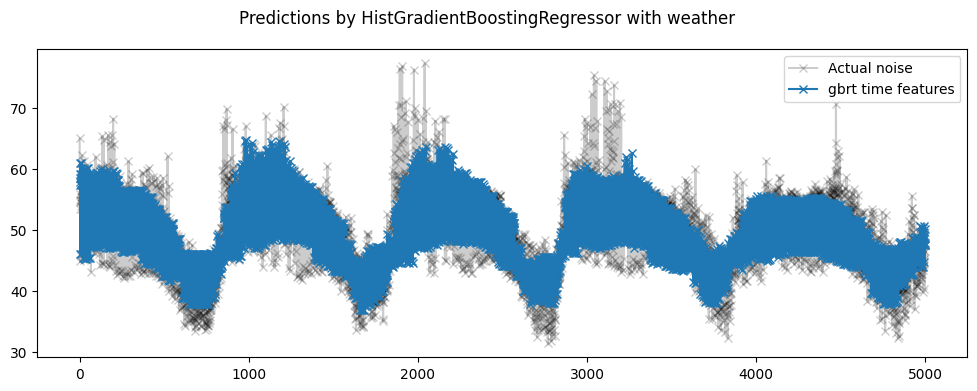

In [36]:
#Qualitative analysis of the impact of features on linear model predictions
gbrt_pipeline.fit(X.iloc[train_0], y.iloc[train_0])
gbrt_predictions = gbrt_pipeline.predict(X.iloc[test_0])

last_hours = slice(-5000, None)
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Predictions by HistGradientBoostingRegressor with weather")
ax.plot(
    y.iloc[test_0].values[last_hours],
    "x-",
    alpha=0.2,
    label="Actual noise",
    color="black",
)
ax.plot(gbrt_predictions[last_hours], "x-", label="gbrt time features")
_ = ax.legend()


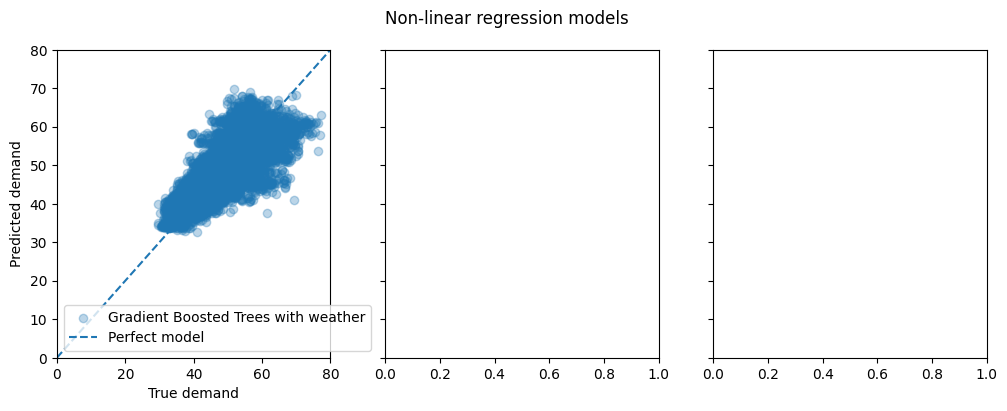

In [37]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 4), sharey=True)
fig.suptitle("Non-linear regression models")
predictions = [
    gbrt_predictions,
]
labels = [
    "Gradient Boosted Trees with weather",
]
for ax, pred, label in zip(axes, predictions, labels):
    ax.scatter(y.iloc[test_0].values, pred, alpha=0.3, label=label)
    ax.plot([0, 80], [0, 80], "--", label="Perfect model")
    ax.set(
        xlim=(0, 80),
        ylim=(0, 80),
        xlabel="True demand",
        ylabel="Predicted demand",
    )
    ax.legend()

plt.show()

In [25]:
#now do the same but look at variables separately: 
# the feature importance should be lower, because dropping a variable form the model 
# will not result in a large decrease of information gain, etc if the other correlated variables take over the task of explaining the model 
#example: you can see that weekend is not as important anymore, because day takes over if weekend is in the model
features=['hour','weekday','month','weekend','holiday','exam_period','LC_HUMIDITY','LC_DWPTEMP','LC_n',
          'LC_RAD','LC_RAININ','LC_DAILYRAIN','LC_WINDDIR','LC_WINDSPEED','LC_RAD60','LC_TEMP_QCL0']
imp = importances(gbrt_pipeline, X, y, features=features) # permutation
#should be on fitted model. I used the X and y but usualy you would need to use the validation set
viz = plot_importances(imp)
viz.view()

NameError: name 'importances' is not defined